In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/MyDrive/ADL final project/data/final_input.csv', index_col = [0])
df.head()

,Open,Close,High,Low,Volume_x,Volume_y,MA,Returns,BBand_upper,BBand_middle,BBand_lower,Average Directional Index,Directional Index,MACD,MACD_signal,MACD hist,stochastic k,stochastic d,movement
0,297.3300,297.325,297.3300,297.3250,0.0225,0.0400,297.035000,0.000388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,297.2400,297.165,297.2400,297.1600,0.1050,0.0412,297.132857,0.000329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,297.9000,297.660,297.9250,297.5145,3.0150,2.6786,297.265714,0.000447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,297.6695,297.785,297.8155,297.5945,3.1800,2.8610,297.403214,0.000462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,297.7850,297.815,297.9255,297.6850,3.0375,2.3263,297.468214,0.000219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [3]:
train_size = int(len(df) * .7)
df_train =  df.iloc[:train_size]
df_val = df.iloc[train_size:]

print(len(df_train), len(df_val))

65218 27951


In [4]:
#Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

feature_columns = ['Open', 'High', 'Low', 'Volume_x', 'Volume_y', 'MA', 'Returns',
       'BBand_upper', 'BBand_middle', 'BBand_lower', 'Directional Index',
       'Average Directional Index', 'MACD', 'MACD_signal', 'MACD hist',
        'stochastic k', 'stochastic d']


for feature in feature_columns:
  df_train[feature] = scaler.fit_transform(df_train[[feature]].values)
  df_val[feature] = scaler.transform(df_val[[feature]])



In [5]:
from tensorflow.keras.utils import to_categorical

Y_train = df_train['movement']
Y_val = df_val['movement']

print(len(Y_train[Y_train == 1]), len(Y_train[Y_train == 0]))
print(len(Y_val[Y_val == 1]), len(Y_val[Y_val == 0]))

Y_train = to_categorical(Y_train, 2)
Y_val = to_categorical(Y_val, 2)

34209 31009
14165 13786


In [6]:
def convert_raw_samples_to_model_samples(scd_log_rtns, movements, window_size):
    X, y = [], []
    len_log_rtns = len(scd_log_rtns)
    for i in range(window_size, len_log_rtns):
        X.append(scd_log_rtns[i-window_size:i])
        y.append(movements[i])
    X, y = np.asarray(X), np.asarray(y)
    #X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y


In [7]:
df_train = df_train.dropna()
df_train.index = np.arange(0,len(df_train))
df_val.index = np.arange(0,len(df_val))

df_train = df_train[feature_columns]
df_val  = df_val[feature_columns]

In [8]:
#Different Window for transformers due to the lack of memory
window_size = 64
X_train, y_train = convert_raw_samples_to_model_samples(df_train, Y_train, window_size)
X_val, y_val = convert_raw_samples_to_model_samples(df_val, Y_val, window_size)

## Embedding

In [9]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [10]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [11]:
# -*- coding: utf-8 -*-
"""Confusion matrix.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1dbeSXmnx5b6mUMXXYMlYVw-V20-fDdPc
"""

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

##Model

In [12]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

In [13]:
def create_transformers(X, embedding, classification):
  
  d_k = 256
  d_v = 256
  n_heads = 12
  ff_dim = 256

  input_seq = Input(shape = (X.shape[1], X.shape[2]))

  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  if embedding:
    time_embedding = Time2Vector(X.shape[1])
    x = time_embedding(input_seq)
    x = Concatenate(axis=-1)([input_seq, x])
    x = attn_layer1((x,x,x))
  else:
    x = attn_layer1((input_seq, input_seq, input_seq))
  
  x = attn_layer2((x,x,x))
  x = attn_layer3((x,x,x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)

  if classification:
    out = Dense(2, activation="softmax", name="output")(x)
    model = Model(inputs = input_seq, outputs = out)
    model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(1e-5), metrics = ['accuracy'])
  else:
    out = Dense(1)(x)
    model = Model(inputs = input_seq, outputs = out)
    model.compile(loss = 'mse', optimizer = 'Adam', metrics = ['mae', 'mape'])
  
  return model


In [14]:
#With Time Embedding
model = create_transformers(X_train, True, True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 17)]     0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 64, 2)        256         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 64, 19)       0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 64, 19)       252786      concatenate[0][0]            

In [15]:
history = model.fit(X_train, y_train,epochs=5,  validation_data=(X_val, y_val))

Epoch 1/5
2036/2036 [==============================] - 729s 347ms/step - loss: 0.6899 - accuracy: 0.6083 - val_loss: 0.6805 - val_accuracy: 0.5810
Epoch 2/5
2036/2036 [==============================] - 718s 353ms/step - loss: 0.6493 - accuracy: 0.6771 - val_loss: 0.6944 - val_accuracy: 0.5620
Epoch 3/5
2036/2036 [==============================] - 713s 350ms/step - loss: 0.5877 - accuracy: 0.7210 - val_loss: 0.8290 - val_accuracy: 0.5334
Epoch 4/5
2036/2036 [==============================] - 686s 337ms/step - loss: 0.4215 - accuracy: 0.8274 - val_loss: 0.9617 - val_accuracy: 0.5249
Epoch 5/5
2036/2036 [==============================] - 737s 362ms/step - loss: 0.3422 - accuracy: 0.8575 - val_loss: 1.0708 - val_accuracy: 0.5253


In [19]:
y_pred = model.predict(X_val)
y_pred = [y_pred[i].argmax() for i in range(len(y_pred))]
print(set(y_pred))

num =[0,0]
for i in range(len(y_pred)):
  num[y_pred[i]] += 1 

print(num)

y_true =  [y_val[i].argmax() for i in range(len(y_val))]
num =[0,0]
for i in range(len(y_true)):
  num[y_true[i]] += 1 
print(num)

{0, 1}
[13640, 14247]
[13753, 14134]


In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.51      0.52     13753
           1       0.53      0.54      0.53     14134

    accuracy                           0.53     27887
   macro avg       0.53      0.53      0.53     27887
weighted avg       0.53      0.53      0.53     27887



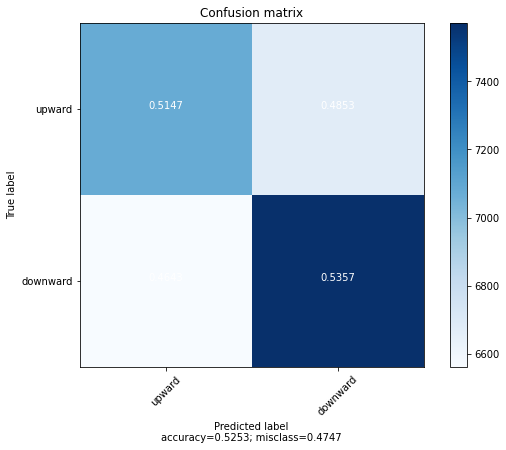

In [21]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm,
                      ['upward','downward'],
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True)